In [1]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image    
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.models.components import feature_extractors
import torchvision
from anomalib.models.components.feature_extractors import TorchFXFeatureExtractor
from torchvision.models.densenet import DenseNet201_Weights
import torch.nn.functional as F
from anomalib.models.components.cluster.kmeans import KMeans
import torchvision.models as models

/work/scratch/tyang/miniconda3/env/anomalib_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config_select.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)


dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/yolov5results
  task: classification # options: [classification, segmentation]
  category: cat0/crops/od
  pre_selection: True
  number_of_samples: 10
  train_batch_size: 1
  eval_batch_size: 1
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop:  # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.001 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.001 # fraction of train/test images held out for validation (usage depends on val_split_mode)

  tiling:
    apply: false
    tile_size: n

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [39]:
MODEL = "patchcore"
CONFIG_similiar_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config_similiar.yaml"
with open(file=CONFIG_similiar_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config_similiar = get_configurable_parameters(config_path=CONFIG_similiar_PATH)

dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/yolov5results
  task: classification # options: [classification, segmentation]
  category: cat0/crops/od
  pre_selection: False
  number_of_samples: 17999
  train_batch_size: 1000
  eval_batch_size: 1000
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop:  # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.1 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.1 # fraction of train/test images held out for validation (usage depends on val_split_mode)

  tiling:
    apply: false
    tile_s

In [40]:
select_data_module = get_datamodule(config=config)
select_data_module.prepare_data()
select_data_module.setup()


/home/students/tyang/anomalib/src/anomalib/data/utils/split.py:110: UserWarning: Zero subset length encountered during splitting. This means one of your subsets might be empty or devoid of either normal or anomalous images.
  warnings.warn(


In [41]:
similiar_data_module = get_datamodule(config=config_similiar)
similiar_data_module.prepare_data()
similiar_data_module.setup()

In [42]:
import torchvision.transforms.functional as TF

invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                                            std = [ 1., 1., 1. ]),
                                            torchvision.transforms.Resize((256,256)),
                                            
                                            ])


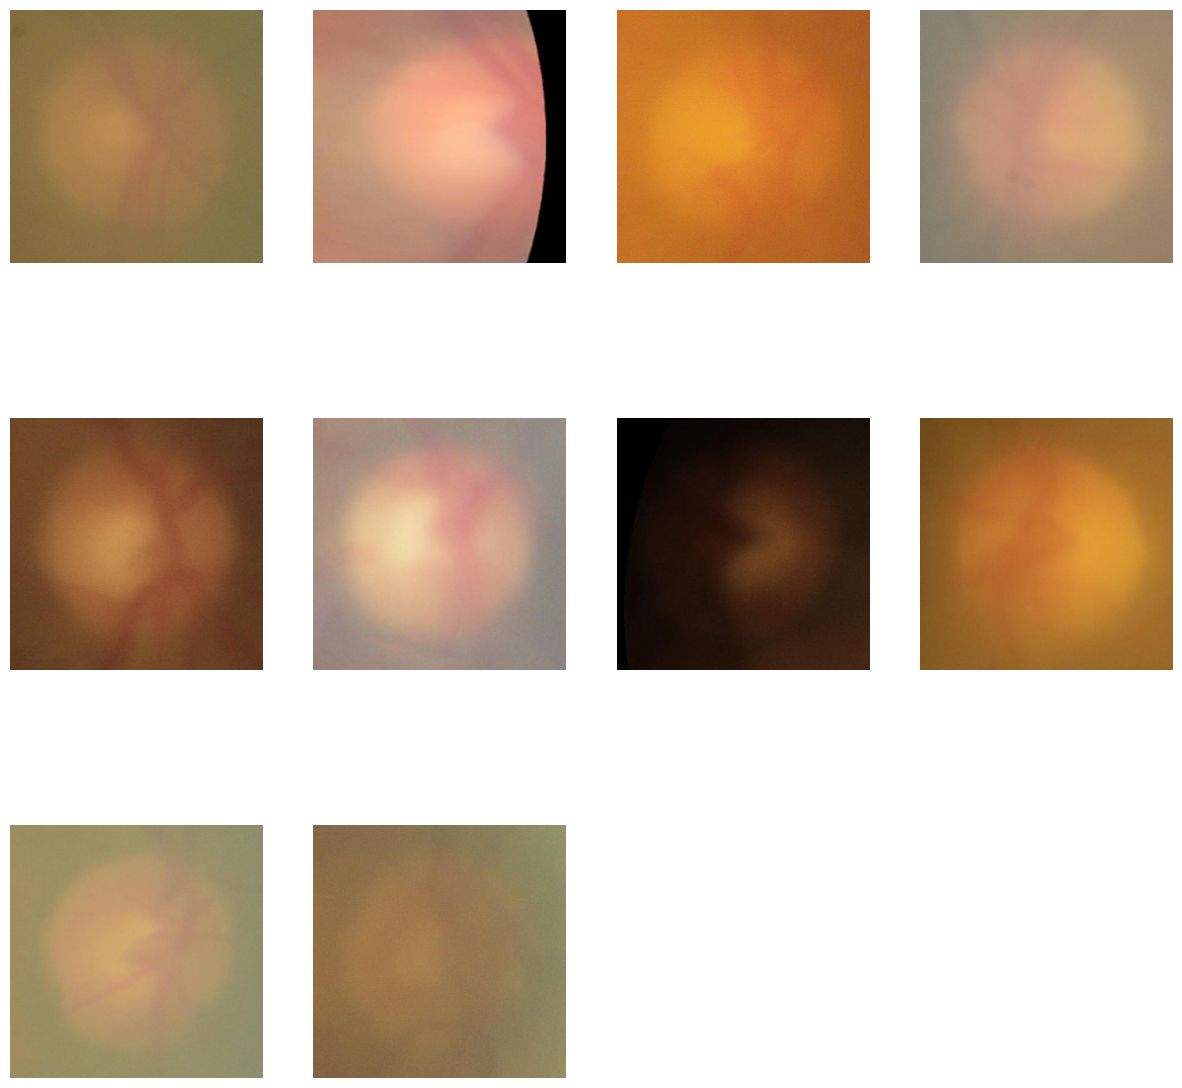

In [43]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

select_data_loader = select_data_module.train_dataloader()

# Number of images to plot and grid dimensions
num_images_to_plot = 10
grid_rows = 3
grid_cols = 4

# Create a figure with a grid of subplots
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed

images_plotted = 0
for i, select_data in enumerate(select_data_loader):
    select_images = select_data["image"]  # Tensor of shape (batch_size, channels, height, width)
    
    for j, img_tensor in enumerate(select_images):
        img_tensor = img_tensor.cpu()  # Move image tensor to CPU if it's on GPU
        conv_img = invTrans(img_tensor)  # Apply any necessary inverse transformations

        # Plot the image in a subplot
        plt.subplot(grid_rows, grid_cols, images_plotted + 1)
        plt.imshow(to_pil_image(conv_img))
        plt.axis('off')

        images_plotted += 1
        if images_plotted == num_images_to_plot:
            break

    if images_plotted == num_images_to_plot:
        break

plt.show()


In [44]:

feature_extractor = TorchFXFeatureExtractor(
                    backbone="densenet201",
                    return_nodes=["features.denseblock1.denselayer6.conv2"],
                    weights=DenseNet201_Weights.IMAGENET1K_V1,
                )


In [45]:
reference_feature_list = []

for  i, train_data in enumerate(select_data_module.train_dataloader()):
    features = feature_extractor(train_data["image"])["features.denseblock1.denselayer6.conv2"]
    reference_feature_list.append(features)

In [46]:
reference_feature_tensor = torch.vstack(reference_feature_list)
print(reference_feature_tensor.shape)

torch.Size([10, 32, 64, 64])


In [47]:
def bag_of_words_statistics(Ptst, Cref, kmeans, S):
    """
    Params:
    Ptst: Feature tensor of a set of images, tensor of shape (N, C, H, W)
    Cref: reference Cluster centers, tensor of shape (K, C)
    S: number of subregions per image dimension, integer

    Returns:
    bow_stats: list of normalized Bag-of-words statistics, possibility-like , length N, each element is a tensor of shape (S * S, K)
    """
    Ptst = torch.vsplit(Ptst, Ptst.shape[0])
    bow_stats = []
    for Itst in Ptst:
        Itst = Itst.squeeze(0)
        #print(Itst.shape)
        subtensors = torch.chunk(Itst, S, dim=1)
        subtensor = [torch.chunk(st, S, dim=2) for st in subtensors]
        
        
        image_bow_stats = torch.zeros(S * S, len(Cref), dtype=torch.float32)
        for i in range(S):
            for j in range(S):
                st_value = subtensor[i][j]
                st_value = st_value.flatten(start_dim=1)
                st_value = st_value.permute(1,0)
               # print(st_value.shape)
                
                cluster_idx = kmeans.predict(st_value)
                #print(cluster_idx.shape)
                cluster_idx = cluster_idx.float()

                hist = torch.histc(cluster_idx, bins = len(Cref), min = torch.min(cluster_idx), max = torch.max(cluster_idx))
                normalized_hist = hist / torch.sum(hist)
                image_bow_stats[i * S + j] = normalized_hist
        
        bow_stats.append(image_bow_stats)
            
        
    return bow_stats


In [48]:
kmeans = torch.load("/home/students/tyang/Documents/kmeans_k5.pt")
cluster_centers = kmeans.cluster_centers_


In [49]:
reference_bow_stats = bag_of_words_statistics(reference_feature_tensor, kmeans.cluster_centers_, kmeans, 4)

In [50]:
print(len(reference_bow_stats))
print(reference_bow_stats[0].shape)

10
torch.Size([16, 5])


In [51]:
global_bow_stats_k5 = torch.load("/home/students/tyang/Documents/global_bow_stats_k5.pt")

In [52]:
def compute_similiarity(bow_stats, bow_stats_ref, select_ratio, step_size):
    """
    Params:
    bow_stats: list of normalized Bag-of-words statistics, possibility-like , length N, each element is a tensor of shape (S * S, K)
    bow_stats_ref:  normalized Bag-of-words statistics of reference image, 
    possibility-like , length N, each element is a tensor of shape (S * S, K)
    step_size: step size of sliding window, integer, should be the same as batchsize

    Returns:
    similiarity: list of similiarity, length N, each element is a tensor of shape (S * S, S * S)
    """
    stacked_bow_stats = torch.stack(bow_stats) # shape is (N, S * S, K)
    #print(stacked_bow_stats.shape)
    bow_stats_ref = bow_stats_ref.unsqueeze(0)  # shape is (1, S * S, K)
   # print(bow_stats_ref.shape)

    stacked_bow_stats[stacked_bow_stats == 0 ] = 1e-10
    bow_stats_ref[bow_stats_ref == 0 ] = 1e-10

    selected_idxs =[]
    selected_distances = []
    for i in range(0, stacked_bow_stats.shape[0], step_size):
        current_bow = stacked_bow_stats[i:i+step_size if i+step_size < stacked_bow_stats.shape[0] else stacked_bow_stats.shape[0], :, :]
        expended_bow_stats_ref = bow_stats_ref.expand(current_bow.shape[0], bow_stats_ref.shape[1], bow_stats_ref.shape[2])

        kl_divegence = F.kl_div(current_bow.log(), expended_bow_stats_ref, reduction="none")
       
        kl_total = torch.sum(kl_divegence, dim=2)
        distance = torch.sum(kl_total, dim=1)
        topk_near_distances,near_idx = torch.topk(distance, k=int(len(distance) * select_ratio), dim=0, largest=False, sorted=True)
        
        selected_idxs.append(near_idx)
        
        selected_distances.append(topk_near_distances)

    return selected_idxs, selected_distances

        
       

    

    

In [53]:
ref0_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[0], select_ratio=0.05, step_size=1000)

In [54]:
def second_selection(index, distance, select_ratio):
    """
    Params:
    idxs: list of selected image indices in each batch , length number of batches
    distances: list of selected image distances, length number of batches
    select_ratio: ratio of selected images compare to all images, float

    Returns:
    selected_idx: list of selected image indices with biggest distances over all in each batches, length number of batches
    """
    selected_distances = [[] for _ in range(len(distance))]
    distance_t = torch.cat(distance)
    topk, global_ids = torch.topk(distance_t, k=int(len(distance_t) * select_ratio ), dim=0, largest=False, sorted=True)
    selected_idxs = [[] for _ in range(len(index))]
    
    for global_id in global_ids:
        batch_id = global_id // index[0].shape[0]
        local_id = global_id % index[0].shape[0]
        selected_idxs[batch_id].append(index[batch_id][local_id])
        selected_distances[batch_id].append(distance_t[global_id])
        
  
    
    return selected_idxs, selected_distances

In [55]:
second_indices,second_dists = second_selection(ref0_idxs, distances, select_ratio=0.3)

In [56]:
print(len(second_indices))
print(len(second_dists))
print(second_indices[0])
print(len(second_indices[0]))
print(len(second_indices[1]))

16
16
[tensor(761), tensor(814), tensor(255), tensor(283), tensor(502), tensor(833), tensor(372), tensor(670)]
8
14


In [57]:
merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    

print(merged_datas["image_path"])

['/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000877.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000941.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000297.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000326.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000577.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000960.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000432.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN000774.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001167.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001540.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001892.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001559.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN001605.jpg', '/home/students/tyang/yolov5results/cat0/crops/od/TRAIN002034.jpg', '/home/students/tyang/yolov5results/cat0/crops/

In [58]:
print(len(merged_datas["image_path"]))

234


In [59]:
import csv 

csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref0_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [60]:
ref1_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[1], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref1_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    

import csv 

csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref1_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)



In [61]:
ref2_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[2], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref2_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref2_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
import csv
ref3_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[3], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref3_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref3_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
ref4_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[4], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref4_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref4_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
ref5_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[5], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref5_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref5_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
ref6_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[6], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref6_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref6_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
ref7_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[7], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref7_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref7_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
import csv

ref8_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[8], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref8_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref8_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
import csv

ref9_idxs,distances = compute_similiarity(global_bow_stats_k5, reference_bow_stats[9], select_ratio=0.05, step_size=1000)
second_indices,second_dists = second_selection(ref9_idxs, distances, select_ratio=0.3)

merged_datas = {"image_path": [], "label": []}
for  i, train_data in enumerate(similiar_data_module.train_dataloader()):
    selected_data = ( {"image_path": train_data["image_path"][second_indice], "label": train_data["label"][second_indice]} for second_indice in second_indices[i] )
    
    
    for data in selected_data:
        for key, values in data.items():
            merged_datas[key].append(values)
    


csv_path = "/home/students/tyang/Documents/similiar_k5_312/category0_ref9_k5.csv"


with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_datas["image_path"])):
            rowdict = {"image_path": merged_datas["image_path"][i], "label": merged_datas["label"][i]}
            writer.writerow(rowdict)

In [ ]:
torch.save(feature_extractor, "/home/students/tyang/Documents/feature_extractor_category0_k5.pt")



In [ ]:
torch.save(kmeans, "/home/students/tyang/Documents/kmeans_category0_k5.pt")